<a href="https://colab.research.google.com/github/sunilkumarrudragada/recommendation_capstone/blob/master/recommendation_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1: Data Understanding & Cleaning

In [2]:
# Import all the required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data_path='/content/drive/MyDrive/Recommendation_Engine/sample30.csv'

In [6]:
df = pd.read_csv(data_path)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (30000, 15)


In [9]:
missing_percent = df.isna().mean() * 100
print(missing_percent)

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64


**Rationale for Removing Columns** <br/>
Only the columns required for sentiment analysis and the recommendation system were retained, such as user identifier (reviews_username), product name (name), review text, and ratings. Other columns were removed because they had a high number of missing values, were not relevant to the problem objective, or could lead to data leakage. In particular, location-related fields, purchase flags, and the pre-existing sentiment column were excluded to ensure a clean and unbiased dataset.

In [10]:
df = df.drop(columns=[
    'id', 'brand', 'categories', 'manufacturer',
    'reviews_date', 'reviews_didPurchase',
    'reviews_doRecommend', 'reviews_userCity',
    'reviews_userProvince', 'user_sentiment'
])

In [11]:
# Drop rows with missing username
df = df.dropna(subset=['reviews_username'])

In [12]:
# Handle missing review titles
df['reviews_title'] = df['reviews_title'].fillna('')

In [13]:
df['review_combined'] = df['reviews_title'] + ' ' + df['reviews_text']

In [14]:
df.head()

,name,reviews_rating,reviews_text,reviews_title,reviews_username,review_combined
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Just Awesome i love this album. it's very good...
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Good Good flavor. This review was collected as...
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Good Good flavor.
3,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Disappointed I read through the reviews on her...
4,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Irritation My husband bought this gel for us. ...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29937 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29937 non-null  object
 1   reviews_rating    29937 non-null  int64 
 2   reviews_text      29937 non-null  object
 3   reviews_title     29937 non-null  object
 4   reviews_username  29937 non-null  object
 5   review_combined   29937 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB


##2: Exploratory Data Analysis (EDA)

###2.1 Distribution of Ratings

Ratings value counts reviews_rating
5    20792
4     6010
1     1373
3     1344
2      418
Name: count, dtype: int64


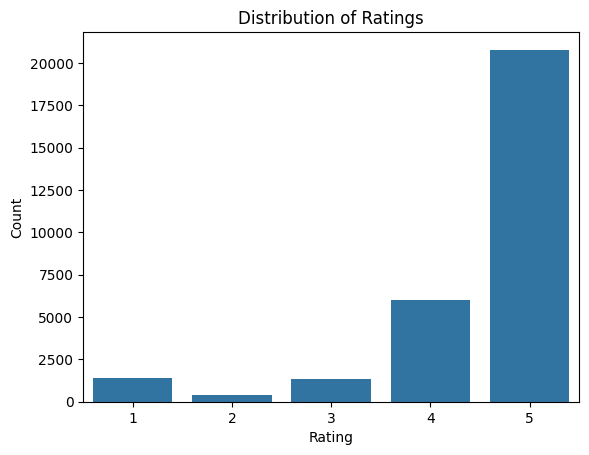

In [16]:
print('Ratings value counts', df['reviews_rating'].value_counts())
sns.countplot(x='reviews_rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Observation:** </br>
The distribution of ratings is highly skewed towards higher values, with a majority of ratings being 4 and 5. This indicates that the dataset is imbalanced and that special care needs to be taken while building the sentiment classification model to ensure that the minority class is properly learned.


### 2.2 Sentiment Distribution


In [17]:
df['sentiment'] = df['reviews_rating'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <=2 else 'neutral'))
df['sentiment'].value_counts()

,count
sentiment,
positive,26802
negative,1791
neutral,1344


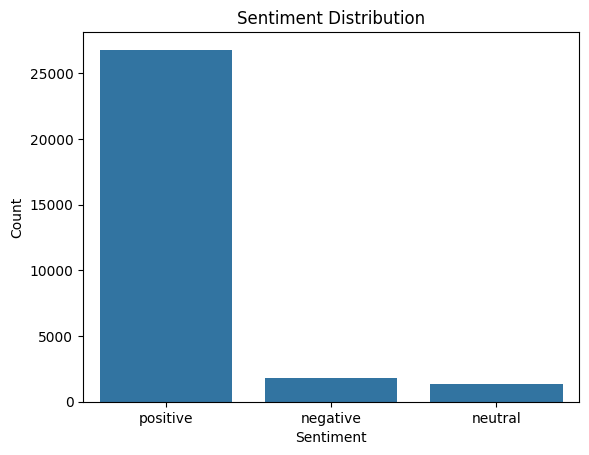

In [18]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [19]:
# Drop neutral reviews
# Reviews with rating 3 were treated as neutral and removed, as they do not clearly
# represent positive or negative sentiment and may introduce noise into the classification model.
df = df[df['sentiment'] != 'neutral']

### 2.3 Review Length Analysis

In [20]:
df['review_length'] = df['review_combined'].apply(lambda x: len(x.split()))
df['review_length'].describe()

,review_length
count,28593.000000
mean,37.061029
std,33.910396
min,1.000000
25%,19.000000
50%,28.000000
75%,44.000000
max,982.000000


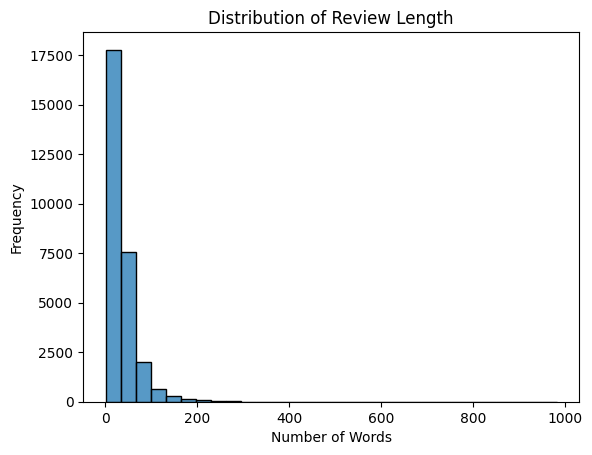

In [21]:
sns.histplot(df['review_length'], bins=30)
plt.title('Distribution of Review Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

**Observation:** </br>
The majority of reviews are short to medium in length, with a median of 28 words, indicating that the dataset contains sufficient textual information for effective sentiment analysis, while a small number of long reviews act as outliers.

### 2.4 Product Activity

In [22]:
# top products by number of reviews
df['name'].value_counts().head(10)

,count
name,
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8454
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2977
Clorox Disinfecting Bathroom Cleaner,2023
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1100
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,1006
"Burt's Bees Lip Shimmer, Raisin",851
The Resident Evil Collection 5 Discs (blu-Ray),822
Nexxus Exxtra Gel Style Creation Sculptor,682
Mike Dave Need Wedding Dates (dvd + Digital),660


## 3: Feature Extraction and Sentiment Model Building


###3.1: Text Preprocessing

In [23]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

**Text Preprocessing:** </br>
The review text was converted to lowercase, and HTML tags, punctuation, and numerical characters were removed to eliminate noise. Stopwords were removed as they do not contribute significantly to sentiment classification. Finally, lemmatization was applied to reduce words to their base form while preserving semantic meaning, resulting in clean and normalized text suitable for feature extraction.

In [24]:
def preprocess_text(text):
  # Lowercase
  text = text.lower()
  # Remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # Remove punctuation and numbers
  text = re.sub(r'[^a-z\s]', '', text)
  # Remove extra whitespaces
  text = re.sub(r'\s+', ' ', text).strip()

  # Tokenize
  words = text.split()

  # Remove stopwords and lemmatize
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

  return ' '.join(words)

In [25]:
df['clean_review'] = df['review_combined'].apply(preprocess_text)

In [26]:
df.head()

,name,reviews_rating,reviews_text,reviews_title,reviews_username,review_combined,sentiment,review_length,clean_review
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Just Awesome i love this album. it's very good...,positive,43,awesome love album good hip hop side current p...
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Good Good flavor. This review was collected as...,positive,12,good good flavor review collected part promotion
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Good Good flavor.,positive,3,good good flavor
3,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Disappointed I read through the reviews on her...,negative,125,disappointed read review looking buying one co...
4,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Irritation My husband bought this gel for us. ...,negative,26,irritation husband bought gel u gel caused irr...


### 3.2 TF-IDF Vectorization

The dataset was split into training and testing sets using a stratified split to preserve the class distribution. TF-IDF vectorization was applied to convert the cleaned text into numerical features. Unigrams and bigrams were considered to capture meaningful phrases, while very common and rare terms were filtered to reduce noise

In [27]:
X=df['clean_review']
y=df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))

In [29]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [30]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

###3.3 Logistic Regression

In [31]:
# Initialize Logistic Regression with class weight
log_reg=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [32]:
y_pred_lr=log_reg.predict(X_test_tfidf)

In [33]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.9655534184297955

Classification Report:

              precision    recall  f1-score   support

    negative       0.68      0.85      0.75       358
    positive       0.99      0.97      0.98      5361

    accuracy                           0.97      5719
   macro avg       0.84      0.91      0.87      5719
weighted avg       0.97      0.97      0.97      5719



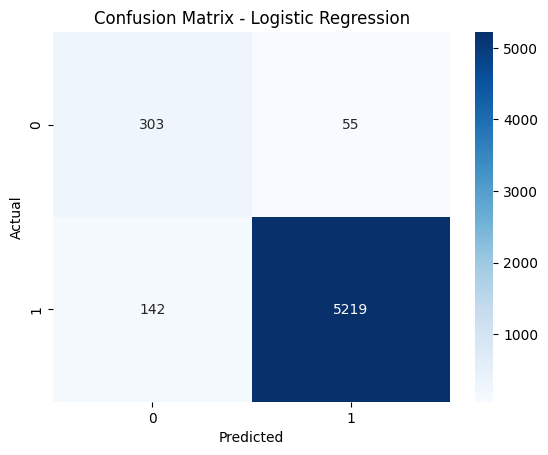

In [34]:
cm=confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

###3.4 Naive Bayes

In [35]:
nb_model=MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [36]:
# Predict
y_pred_nb = nb_model.predict(X_test_tfidf)

In [37]:
#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.9580346214373142

Classification Report:

              precision    recall  f1-score   support

    negative       0.98      0.34      0.50       358
    positive       0.96      1.00      0.98      5361

    accuracy                           0.96      5719
   macro avg       0.97      0.67      0.74      5719
weighted avg       0.96      0.96      0.95      5719



###3.5 Random Forest

In [38]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [39]:
y_pred_rf=rf_model.predict(X_test_tfidf)

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9702745235180976

Classification Report:

              precision    recall  f1-score   support

    negative       0.99      0.53      0.69       358
    positive       0.97      1.00      0.98      5361

    accuracy                           0.97      5719
   macro avg       0.98      0.76      0.84      5719
weighted avg       0.97      0.97      0.97      5719



Three different machine learning models—Logistic Regression, Multinomial Naive Bayes, and Random Forest—were evaluated for sentiment classification. Although Random Forest achieved the highest overall accuracy, its recall for the negative sentiment class was significantly lower. Logistic Regression demonstrated the best balance between precision, recall, and F1-score for the minority class while maintaining high overall accuracy. Therefore, Logistic Regression was selected as the final sentiment classification model.

### 3.6 Model Comparison and Selection

In [41]:
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_rf)
    ]
})

model_comparison

,Model,Accuracy
0,Logistic Regression,0.965553
1,Naive Bayes,0.958035
2,Random Forest,0.970275


##4: Recommendation System and Sentiment-Based Product Recommendation

###4.1: Prepare Data for Recommendation System

In [42]:
reco_df=df[['reviews_username', 'name', 'reviews_rating']]

In [43]:
reco_df.head()

,reviews_username,name,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1


###4.2: Train–Test Split for Recommendation System

In [44]:
train_data, test_data = train_test_split(reco_df, test_size=0.2, random_state=42)


In [45]:
train_data.shape

(22874, 3)

In [46]:
test_data.shape

(5719, 3)

###4.3: User–Item Matrix

In [47]:
user_item_matrix = train_data.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [48]:
user_item_matrix.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###4.4 User-Based Collaborative Filtering

####4.4.1 Compute User Similarity (Cosine)

In [49]:
user_tem_filled = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_tem_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [50]:
user_similarity_df.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zozo0o,zsarah,zsazsa,zt313,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


####4.4.2: Function to Recommend Products

In [51]:
def user_based_recommendations(user, user_item_matrix, user_similarity_df, n_recommendations=20):

    # Similar users with similarity > 0
    similar_users = user_similarity_df[user].drop(user).sort_values(ascending=False)
    similar_users = similar_users[similar_users > 0]

    if similar_users.empty:
        return "Not enough data to make recommendations for this user."

    # Items already rated by the user
    user_rated_items = user_item_matrix.loc[user].dropna().index

    # Weighted ratings
    weighted_ratings = user_item_matrix.loc[similar_users.index].T.dot(similar_users)
    similarity_sum = similar_users.sum()

    # Avoid division by zero
    scores = weighted_ratings / similarity_sum

    # Remove already rated items
    scores = scores.drop(user_rated_items, errors='ignore')

    # Drop NaN scores explicitly
    scores = scores.dropna()

    return scores.sort_values(ascending=False).head(n_recommendations)

####4.4.3: Test User-Based Recommendations

In [52]:
sample_user = user_item_matrix.index[0]

user_based_recommendations(
    sample_user,
    user_item_matrix,
    user_similarity_df,
    n_recommendations=20
)

,0
name,


In [53]:
sample_user = user_item_matrix.index[130]

user_based_recommendations(
    sample_user,
    user_item_matrix,
    user_similarity_df,
    n_recommendations=20
)


,0
name,


**Observation:** </br>
Although a user-based collaborative filtering approach was implemented, it was observed that due to sparse user–item interactions, meaningful similarity scores could not be computed for many users. After handling division-by-zero and invalid similarity cases, the model did not generate recommendations for several users. This limitation highlights the scalability issue of user-based collaborative filtering and motivated the use of item-based collaborative filtering for final recommendations.

###4.5 Item–Item Collaborative Filtering(Adjusted Cosine)

####4.5.1 User–Item Rating Matrix

In [54]:
# Pivot table: users × items
df_pivot = train_data.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


####4.5.2 User Mean Ratings

In [55]:
user_mean_ratings = df_pivot.mean(axis=1)

In [56]:
user_mean_ratings.head()

,0
reviews_username,
00dog3,4.0
00sab00,1.0
02dakota,5.0
02deuce,4.0
0325home,5.0


In [57]:
# Mean-centered ratings
df_adjusted = df_pivot.sub(user_mean_ratings, axis=0)

df_adjusted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


####4.5.3 Item–Item Similarity (Cosine)

In [58]:
# Replace NaN with 0 only for similarity computation
df_adjusted_filled = df_adjusted.fillna(0)

# Item-item similarity matrix
item_similarity = cosine_similarity(df_adjusted_filled.T)

item_similarity_df = pd.DataFrame(
    item_similarity,
    index=df_adjusted.columns,
    columns=df_adjusted.columns
)

item_similarity_df.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.126588,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


####4.5.4: Item-Based Recommendation Function

In [59]:
def item_based_recommendations(user, df_pivot, item_similarity_df, n_recommendations=20):

    user_ratings = df_pivot.loc[user].dropna()

    if user_ratings.empty:
        return "User has no ratings."

    scores = item_similarity_df[user_ratings.index].dot(user_ratings)
    scores = scores.drop(user_ratings.index, errors='ignore')

    # Remove zero scores
    scores = scores[scores > 0]

    return scores.sort_values(ascending=False).head(n_recommendations)

####4.5.5: Test Item-Based Recommendations

In [60]:
sample_user = df_pivot.index[0]

item_based_recommendations(
    sample_user,
    df_pivot,
    item_similarity_df,
    n_recommendations=20
)

,0
name,
Power Crunch Protein Energy Bar Peanut Butter Creme Original,0.528336
"Burt's Bees Lip Shimmer, Raisin",0.296068
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.266916
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,0.208737
Mike Dave Need Wedding Dates (dvd + Digital),0.079044
"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0.014722
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,0.003558


In [61]:
sample_user = df_pivot.index[1]

item_based_recommendations(
    sample_user,
    df_pivot,
    item_similarity_df,
    n_recommendations=20
)

,0
name,
"Newman's Own Balsamic Vinaigrette, 16.0oz",0.135208
"Iman Second To None Stick Foundation, Clay 1",0.105873
"Coty Airspun Face Powder, Translucent Extra Coverage",0.084970
Pantene Pro-V Expert Collection Age Defy Conditioner,0.074111
"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",0.066129
Kind Nut Delight Bar,0.065877
Clorox Disinfecting Bathroom Cleaner,0.064929
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),0.062459
Jason Aldean - They Don't Know,0.052897


In [62]:
sample_user = df_pivot.index[13]

item_based_recommendations(
    sample_user,
    df_pivot,
    item_similarity_df,
    n_recommendations=20
)

,0
name,
Clorox Disinfecting Bathroom Cleaner,1.134786
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),0.485529
"Iman Second To None Stick Foundation, Clay 1",0.475686
Meguiars Interior Detailer Wipes 25ct,0.462262
Tostitos Simply Blue Corn Tortilla Chips,0.446268
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,0.429568
Pantene Pro-V Expert Collection Age Defy Conditioner,0.332980
There's Something About Mary (dvd),0.304769
Kind Nut Delight Bar,0.295982


**Observation:** </br>
The item-based collaborative filtering model successfully generated recommendations with non-zero similarity scores for products that are closely related to items previously rated by the user. Products with zero scores indicate no meaningful similarity signal and were excluded from the final recommendation list.

**Final Recommendation System Selection**

**User-Based Collaborative Filtering:**
Due to sparse user–item interactions, the user-based collaborative filtering approach was unable to generate meaningful recommendations for many users.

**Item-Based Collaborative Filtering:**
In contrast, the item-based collaborative filtering approach using adjusted cosine similarity produced stable and relevant recommendations.

**Final Selection:**
Therefore, item-based collaborative filtering was selected as the final recommendation system, as it performs better in sparse e-commerce datasets and provides more reliable recommendations.

###4.6: Sentiment-Based Filtering to Fetch Top 5 Product Recommendation

####4.6.1: Top 20 Recommended Products for a User

In [63]:
sample_user = df_pivot.index[5]
top_20_items = item_based_recommendations(
    sample_user,
    df_pivot,
    item_similarity_df,
    n_recommendations=20
)

top_20_items


,0
name,
Clorox Disinfecting Bathroom Cleaner,1.134786
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),0.485529
"Iman Second To None Stick Foundation, Clay 1",0.475686
Meguiars Interior Detailer Wipes 25ct,0.462262
Tostitos Simply Blue Corn Tortilla Chips,0.446268
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,0.429568
Pantene Pro-V Expert Collection Age Defy Conditioner,0.332980
There's Something About Mary (dvd),0.304769
Kind Nut Delight Bar,0.295982


####4.6.3: Fetch All Reviews for These 20 Products

In [64]:
top_20_product_names = top_20_items.index.tolist()

top_20_reviews = df[df['name'].isin(top_20_product_names)]

In [65]:
top_20_reviews

,name,reviews_rating,reviews_text,reviews_title,reviews_username,review_combined,sentiment,review_length,clean_review
1469,Yes To Carrots Nourishing Body Wash,1,"I was not impressed with this product at all, ...",basically like the shampoo only thicker.,mayorkimbee,basically like the shampoo only thicker. I was...,negative,41,basically like shampoo thicker impressed produ...
1470,Yes To Carrots Nourishing Body Wash,1,I am pretty disappointed with this body wash. ...,Not Good,cinizzy,Not Good I am pretty disappointed with this bo...,negative,47,good pretty disappointed body wash lather well...
1471,Yes To Carrots Nourishing Body Wash,2,I just used this for the first time. It smells...,mixed feelings,animn35,mixed feelings I just used this for the first ...,negative,111,mixed feeling used first time smell great feel...
1472,Yes To Carrots Nourishing Body Wash,2,The plastic is soooo dang hard on this bottle ...,need a redesign on the spout and bottle,deewill617,need a redesign on the spout and bottle The pl...,negative,95,need redesign spout bottle plastic soooo dang ...
1475,Yes To Carrots Nourishing Body Wash,4,Love love love this shower gel! It smells amaz...,"Great product, poor construction.",coletteg,"Great product, poor construction. Love love lo...",positive,63,great product poor construction love love love...
...,...,...,...,...,...,...,...,...,...
28758,Meguiars Interior Detailer Wipes 25ct,5,"Everything went smoothly, love the prices and ...",,mrpontiac,"Everything went smoothly, love the prices and...",positive,20,everything went smoothly love price ease trans...
28759,Meguiars Interior Detailer Wipes 25ct,5,Best price for the item I needed. Very fast sh...,,tshollar289,Best price for the item I needed. Very fast s...,positive,19,best price item needed fast shipping consumer ...
28760,Meguiars Interior Detailer Wipes 25ct,5,Autoplicity agent was very helpful over the ph...,,bizmartinez,Autoplicity agent was very helpful over the p...,positive,43,autoplicity agent helpful phone answered quest...
28761,Meguiars Interior Detailer Wipes 25ct,5,Best price on the net! Haven't got my order ye...,,s.hiles,Best price on the net! Haven't got my order y...,positive,19,best price net havent got order yet shipped see


####4.6.4 Predict Sentiment for above Reviews

In [66]:
# Transform review text
top_20_reviews_tfidf = tfidf_vectorizer.transform(top_20_reviews['clean_review'])

# Predict sentiment
top_20_reviews['predicted_sentiment'] = log_reg.predict(top_20_reviews_tfidf)

/tmp/ipython-input-2048147902.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_reviews['predicted_sentiment'] = log_reg.predict(


In [69]:
top_20_reviews.head()

,name,reviews_rating,reviews_text,reviews_title,reviews_username,review_combined,sentiment,review_length,clean_review,predicted_sentiment
1469,Yes To Carrots Nourishing Body Wash,1,"I was not impressed with this product at all, ...",basically like the shampoo only thicker.,mayorkimbee,basically like the shampoo only thicker. I was...,negative,41,basically like shampoo thicker impressed produ...,negative
1470,Yes To Carrots Nourishing Body Wash,1,I am pretty disappointed with this body wash. ...,Not Good,cinizzy,Not Good I am pretty disappointed with this bo...,negative,47,good pretty disappointed body wash lather well...,negative
1471,Yes To Carrots Nourishing Body Wash,2,I just used this for the first time. It smells...,mixed feelings,animn35,mixed feelings I just used this for the first ...,negative,111,mixed feeling used first time smell great feel...,negative
1472,Yes To Carrots Nourishing Body Wash,2,The plastic is soooo dang hard on this bottle ...,need a redesign on the spout and bottle,deewill617,need a redesign on the spout and bottle The pl...,negative,95,need redesign spout bottle plastic soooo dang ...,negative
1475,Yes To Carrots Nourishing Body Wash,4,Love love love this shower gel! It smells amaz...,"Great product, poor construction.",coletteg,"Great product, poor construction. Love love lo...",positive,63,great product poor construction love love love...,negative


In [68]:
sentiment_summary = (
    top_20_reviews
    .groupby('name')['predicted_sentiment']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)

# Keep only positive sentiment
positive_sentiment = sentiment_summary[
    sentiment_summary['predicted_sentiment'] == 'positive'
]

positive_sentiment


,name,predicted_sentiment,percentage
0,"All,bran Complete Wheat Flakes, 18 Oz.",positive,0.909091
2,Bisquick Original Pancake And Baking Mix - 40oz,positive,1.000000
3,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",positive,0.977011
5,Chex Muddy Buddies Brownie Supreme Snack Mix,positive,0.851852
7,Clorox Disinfecting Bathroom Cleaner,positive,0.990114
9,Hoover174 Platinum Collection153 Lightweight B...,positive,0.826471
11,"Iman Second To None Stick Foundation, Clay 1",positive,0.785714
13,Jason Aldean - They Don't Know,positive,0.963918
15,Kind Nut Delight Bar,positive,0.800000
17,Meguiars Interior Detailer Wipes 25ct,positive,0.937500


In [70]:
top_5_products = (
    positive_sentiment
    .sort_values(by='percentage', ascending=False)
    .head(5)
)

top_5_products


,name,predicted_sentiment,percentage
2,Bisquick Original Pancake And Baking Mix - 40oz,positive,1.000000
29,Stander Pt Bedcane - Bed Handle,positive,1.000000
25,Planes: Fire Rescue (2 Discs) (includes Digita...,positive,0.990909
7,Clorox Disinfecting Bathroom Cleaner,positive,0.990114
30,Stargate (ws) (ultimate Edition) (director's C...,positive,0.977778


##5: Saving Trained Models for Deployment


In [71]:
import pickle

# Save sentiment model
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save pivot table
with open('user_item_pivot.pkl', 'wb') as f:
    pickle.dump(df_pivot, f)

# Save item similarity matrix
with open('item_similarity.pkl', 'wb') as f:
    pickle.dump(item_similarity_df, f)

# Save cleaned dataframe
with open('reviews_df.pkl', 'wb') as f:
    pickle.dump(df, f)


In [73]:
ls

drive/               reviews_df.pkl  sentiment_model.pkl   user_item_pivot.pkl
item_similarity.pkl  sample_data/    tfidf_vectorizer.pkl


In [74]:
from google.colab import files

files.download('sentiment_model.pkl')
files.download('tfidf_vectorizer.pkl')
files.download('user_item_pivot.pkl')
files.download('item_similarity.pkl')
files.download('reviews_df.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>